<a href="https://colab.research.google.com/github/jazila-begum/bakery-sales-analysis/blob/main/bakery_sales_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Example path – adjust based on your actual Drive folder
zip_path = "/content/drive/MyDrive/archive (3).zip"

import zipfile
import os
import pandas as pd # Import the pandas library and alias it as pd

# Extract to current working directory or custom folder
extract_path = "/content/bakery_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)

['Bakery Sales.csv', 'Bakery price.csv']

In [ ]:


# List extracted files
os.listdir(extract_path)
sales_df = pd.read_csv(f"{extract_path}/Bakery Sales.csv")
price_df = pd.read_csv(f"{extract_path}/Bakery price.csv")

In [ ]:
# Total KPIs
total_orders = len(sales_df)
total_revenue = sales_df['total'].sum()
average_order_value = sales_df['total'].mean()

# Peak performance
peak_hour = sales_df['hour'].value_counts().idxmax()
best_selling_item = summary_df[summary_df['item'] != 'wiener'].sort_values('units_sold', ascending=False).iloc[0]['item']

# KPI Display
from IPython.display import display, Markdown
display(Markdown(f"""
### 🧁 Bakery KPI Dashboard
- 📦 **Total Orders:** {total_orders:,}
- 💰 **Total Revenue:** ₩{total_revenue:,.0f}
- 💳 **Average Order Value (AOV):** ₩{average_order_value:,.0f}
- ⏰ **Peak Hour:** {peak_hour}:00
- 🥐 **Best-Selling Item (Excl. Wiener):** `{best_selling_item.replace('_', ' ').title()}`
"""))


KeyError: 'hour'

In [ ]:
print(price_df.columns.tolist())


['Name', 'price']


In [ ]:
# 🧹 Clean column names
sales_df.columns = [col.strip().lower().replace(" ", "_") for col in sales_df.columns]
price_df.columns = [col.strip().lower().replace(" ", "_") for col in price_df.columns]

# Rename and clean the item name column
price_df.rename(columns={'name': 'item'}, inplace=True)
price_df['item'] = price_df['item'].str.strip().str.lower().str.replace(" ", "_")


In [ ]:
invalid_items = [item for item in price_df['item'] if item not in sales_df.columns]
print("❌ Items NOT in sales data:", invalid_items)


❌ Items NOT in sales data: ['ice_coffe', 'ice_coffe_latter', 'ice_milk_tea', 'valina_latte', 'delivery_fee']


In [ ]:
# Manual correction map
corrections = {
    'ice_coffe': 'americano',
    'ice_coffe_latter': 'caffe_latte',
    'ice_milk_tea': 'milk_tea',
    'valina_latte': 'vanila_latte',  # typo fix
    'delivery_fee': None  # not a product
}

# Apply corrections to price_df
price_df['item'] = price_df['item'].replace(corrections)

# Remove entries we can't correct
price_df = price_df[price_df['item'].notnull()]


In [ ]:
product_cols = [item for item in price_df['item'] if item in sales_df.columns]


In [ ]:
basket = sales_df[product_cols].applymap(lambda x: 1 if x > 0 else 0)

frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules_sorted = rules.sort_values(by="lift", ascending=False)
rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


<ipython-input-31-23ac12c5e27b>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = sales_df[product_cols].applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
20,(plain_bread),(jam),0.072344,0.224037,2.702705
21,(jam),(plain_bread),0.072344,0.872727,2.702705
29,(croissant),(pain_au_chocolat),0.087415,0.310576,1.404204
28,(pain_au_chocolat),(croissant),0.087415,0.395230,1.404204
38,(pain_au_chocolat),"(angbutter, croissant)",0.061417,0.277683,1.320737
37,"(angbutter, croissant)",(pain_au_chocolat),0.061417,0.292115,1.320737
36,"(pain_au_chocolat, angbutter)",(croissant),0.061417,0.370455,1.316180
39,(croissant),"(pain_au_chocolat, angbutter)",0.061417,0.218206,1.316180
22,(plain_bread),(croissant),0.103617,0.320887,1.140072
23,(croissant),(plain_bread),0.103617,0.368139,1.140072


In [ ]:
print("🛠 Corrected Items:")
for k, v in corrections.items():
    if v:
        print(f"  '{k}' → '{v}'")


🛠 Corrected Items:
  'ice_coffe' → 'americano'
  'ice_coffe_latter' → 'caffe_latte'
  'ice_milk_tea' → 'milk_tea'
  'valina_latte' → 'vanila_latte'


In [ ]:
# 🕒 5. DateTime Processing
sales_df['datetime'] = pd.to_datetime(sales_df['datetime'])
sales_df['date'] = sales_df['datetime'].dt.date
sales_df['month'] = sales_df['datetime'].dt.month
sales_df['hour'] = sales_df['datetime'].dt.hour
sales_df['day_name'] = sales_df['datetime'].dt.day_name()

In [ ]:
for item in price_df['item']:
    if item in sales_df.columns:
        price = float(price_df.loc[price_df['item'] == item, 'price'].values[0])
        sales_df[f'{item}_revenue'] = sales_df[item] * price


In [ ]:
print("Total Orders:", len(sales_df))
print("Total Revenue: ₩{:,}".format(int(sales_df['total'].sum())))

# Only include items that are columns in sales_df
valid_items = [item for item in price_df['item'] if item in sales_df.columns]
print("Total Items Sold:", int(sales_df[valid_items].sum().sum()))


Total Orders: 2654
Total Revenue: ₩51,237,500
Total Items Sold: 10840


In [ ]:
# 📦 9. Product Summary
summary = []
for item in price_df['item']:
    if item in sales_df.columns:
        units = sales_df[item].sum()
        revenue = sales_df[f'{item}_revenue'].sum()
        summary.append({'item': item.replace("_", " ").title(), 'units_sold': units, 'revenue': revenue})

summary_df = pd.DataFrame(summary).sort_values(by='revenue', ascending=False)


<ipython-input-37-8a0e17ec080c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df.head(10), x='item', y='revenue', palette='rocket')


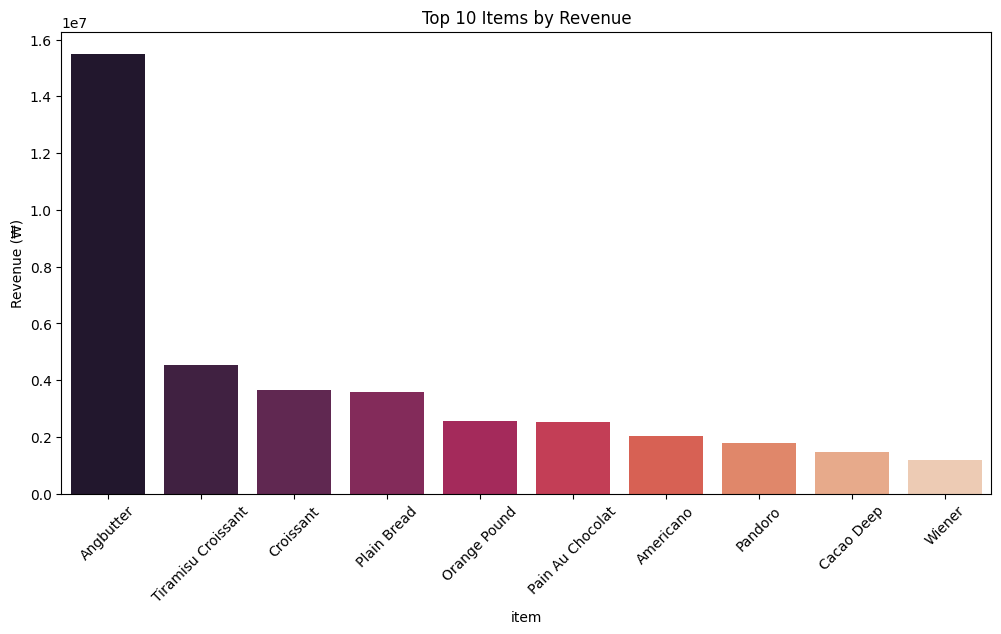

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 🔝 Top 10 by Revenue
plt.figure(figsize=(12,6))
sns.barplot(data=summary_df.head(10), x='item', y='revenue', palette='rocket')
plt.title("Top 10 Items by Revenue")
plt.xticks(rotation=45)
plt.ylabel("Revenue (₩)")
plt.show()

<ipython-input-75-dfe30f6958bf>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df.head(10), x='item', y='units_sold', palette='viridis')


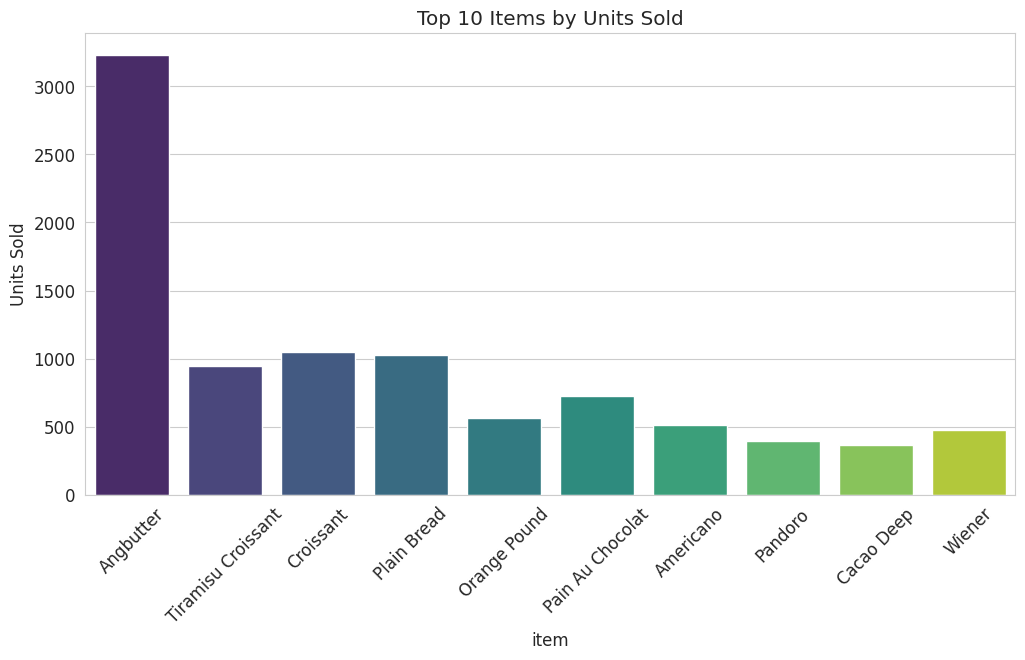

In [ ]:
# 🔝 Top 10 by Quantity
plt.figure(figsize=(12,6))
sns.barplot(data=summary_df.head(10), x='item', y='units_sold', palette='viridis')
plt.title("Top 10 Items by Units Sold")
plt.xticks(rotation=45)
plt.ylabel("Units Sold")
plt.show()

<ipython-input-74-a520f16ca4ec>:18: UserWarning: Glyph 128339 (\N{CLOCK FACE FOUR OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128339 (\N{CLOCK FACE FOUR OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


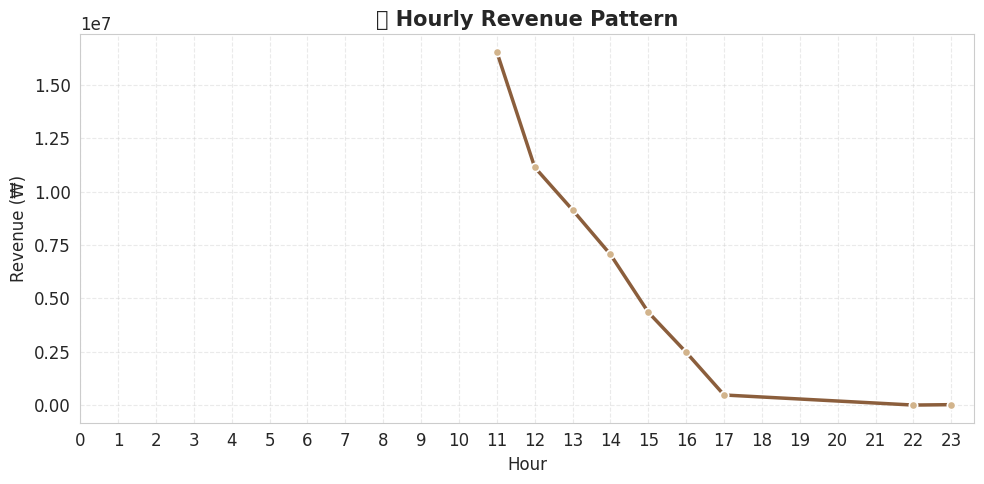

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=hourly,
    x='hour',
    y='total',
    marker='o',
    color='#8B5E3C',         # Warm coffee brown
    linewidth=2.5,
    markerfacecolor='#D2B48C',  # Soft tan marker fill
    markeredgewidth=1.2
)

plt.title("🕓 Hourly Revenue Pattern", fontsize=15, fontweight='bold')
plt.xlabel("Hour")
plt.ylabel("Revenue (₩)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


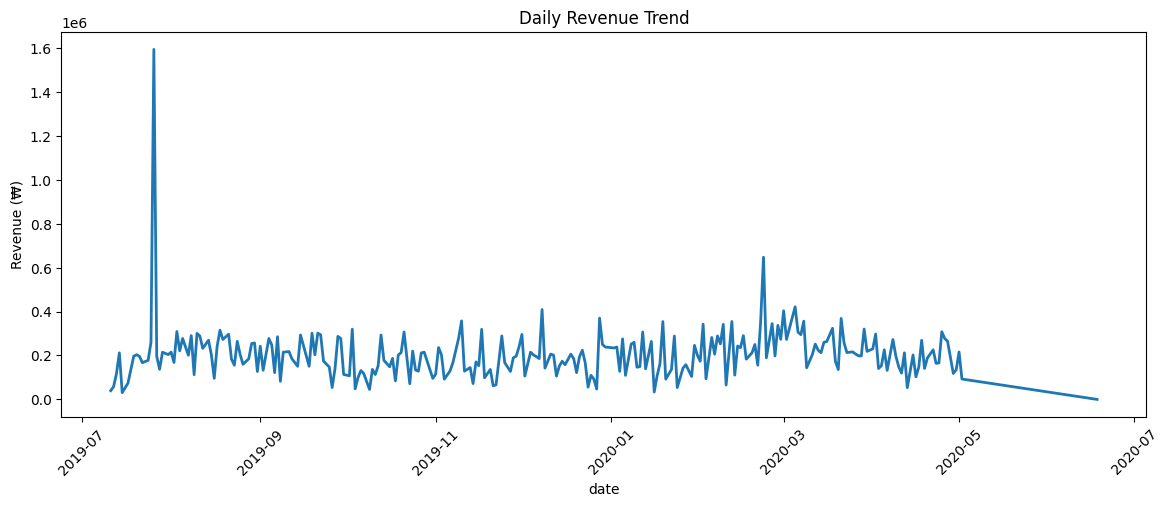

In [ ]:
# 📆 10. Time Series
daily_revenue = sales_df.groupby('date')['total'].sum().reset_index()

plt.figure(figsize=(14,5))
sns.lineplot(data=daily_revenue, x='date', y='total', linewidth=2)
plt.title("Daily Revenue Trend")
plt.ylabel("Revenue (₩)")
plt.xticks(rotation=45)
plt.show()

<ipython-input-40-90df5d544cb6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dow_revenue, x='day_name', y='total', palette='mako')


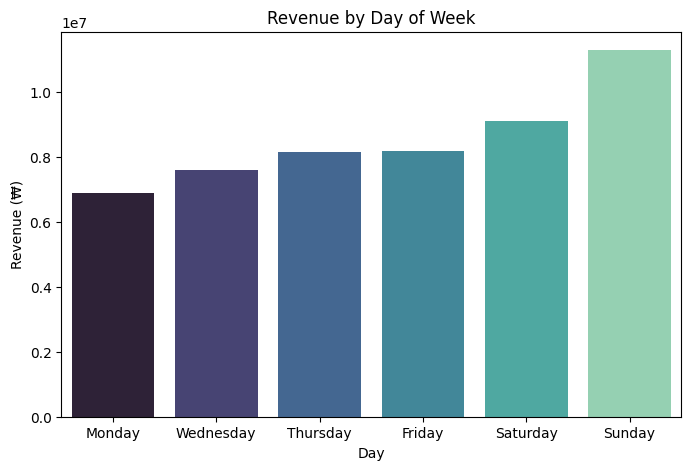

In [ ]:
# 📅 11. Revenue by Day of Week
dow_order = ['Monday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_revenue = sales_df.groupby('day_name')['total'].sum().reindex(dow_order).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=dow_revenue, x='day_name', y='total', palette='mako')
plt.title("Revenue by Day of Week")
plt.ylabel("Revenue (₩)")
plt.xlabel("Day")
plt.show()

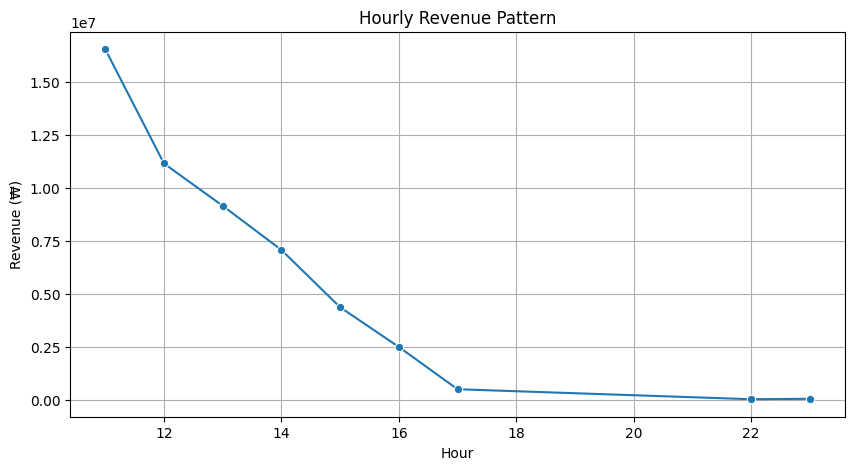

In [ ]:
# 🕓 12. Hourly Revenue
hourly = sales_df.groupby('hour')['total'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly, x='hour', y='total', marker='o')
plt.title("Hourly Revenue Pattern")
plt.xlabel("Hour")
plt.ylabel("Revenue (₩)")
plt.grid(True)
plt.show()

<ipython-input-42-3ab4d63c8d40>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_places, x='place', y='total_revenue', palette='flare')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANG

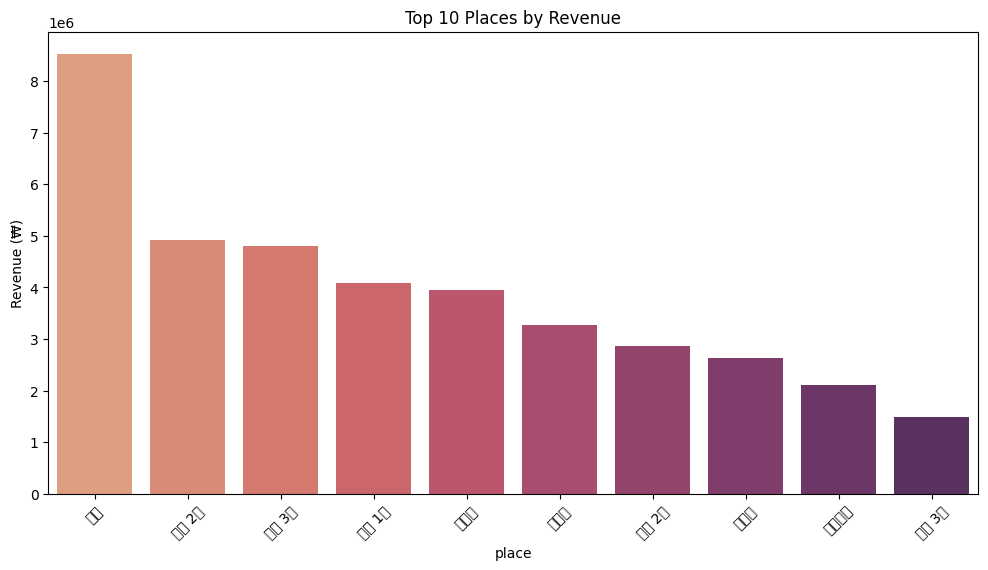

In [ ]:
# 🗺️ 13. Place-wise Revenue
place_perf = sales_df.groupby('place')['total'].agg(['count', 'sum']).reset_index().rename(columns={'count': 'order_count', 'sum': 'total_revenue'})
top_places = place_perf.sort_values(by='total_revenue', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_places, x='place', y='total_revenue', palette='flare')
plt.title("Top 10 Places by Revenue")
plt.xticks(rotation=45)
plt.ylabel("Revenue (₩)")
plt.show()

In [ ]:
# 📦 14. Market Basket Analysis
!pip install -q mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

product_cols = price_df['item'].tolist()
basket = sales_df[product_cols] > 0

frequent_items = apriori(basket, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.2)

# Show top rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
0,(plain_bread),(jam),0.072344,0.224037,2.702705
1,(jam),(plain_bread),0.072344,0.872727,2.702705
3,(croissant),(pain_au_chocolat),0.087415,0.310576,1.404204
2,(pain_au_chocolat),(croissant),0.087415,0.395230,1.404204
5,"(angbutter, croissant)",(pain_au_chocolat),0.061417,0.292115,1.320737
6,(pain_au_chocolat),"(angbutter, croissant)",0.061417,0.277683,1.320737
4,"(pain_au_chocolat, angbutter)",(croissant),0.061417,0.370455,1.316180
7,(croissant),"(pain_au_chocolat, angbutter)",0.061417,0.218206,1.316180


In [ ]:
# 📦 Market Basket Analysis (Final Version)

# ✅ 1. Keep only valid product columns
product_cols = [item for item in price_df['item'] if item in sales_df.columns]

# ✅ 2. Create binary basket (True/False for item presence)
basket = sales_df[product_cols].applymap(lambda x: 1 if x > 0 else 0)

# ✅ 3. Run Apriori algorithm
from mlxtend.frequent_patterns import apriori, association_rules

# Minimum support: items appearing in at least 5% of orders
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

# ✅ 4. Generate Association Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# ✅ 5. Display Top Rules
rules_sorted = rules.sort_values(by="lift", ascending=False)

# Show top 10 rules
rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


<ipython-input-44-5492c5035d17>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = sales_df[product_cols].applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
20,(plain_bread),(jam),0.072344,0.224037,2.702705
21,(jam),(plain_bread),0.072344,0.872727,2.702705
29,(croissant),(pain_au_chocolat),0.087415,0.310576,1.404204
28,(pain_au_chocolat),(croissant),0.087415,0.395230,1.404204
38,(pain_au_chocolat),"(angbutter, croissant)",0.061417,0.277683,1.320737
37,"(angbutter, croissant)",(pain_au_chocolat),0.061417,0.292115,1.320737
36,"(pain_au_chocolat, angbutter)",(croissant),0.061417,0.370455,1.316180
39,(croissant),"(pain_au_chocolat, angbutter)",0.061417,0.218206,1.316180
22,(plain_bread),(croissant),0.103617,0.320887,1.140072
23,(croissant),(plain_bread),0.103617,0.368139,1.140072


from matplotlib import pyplot as plt
_df_0['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['confidence'].plot(kind='hist', bins=20, title='confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['lift'].plot(kind='hist', bins=20, title='lift')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('antecedents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('consequents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='support', y='confidence', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='confidence', y='lift', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['confidence'].plot(kind='line', figsize=(8, 4), title='confidence')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['lift'].plot(kind='line', figsize=(8, 4), title='lift')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['consequents'].value_counts()
    for x_label, grp in _df_10.groupby('antecedents')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('antecedents')
_ = plt.ylabel('consequents')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='support', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['consequents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='support', y='consequents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='confidence', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['consequents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='confidence', y='consequents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

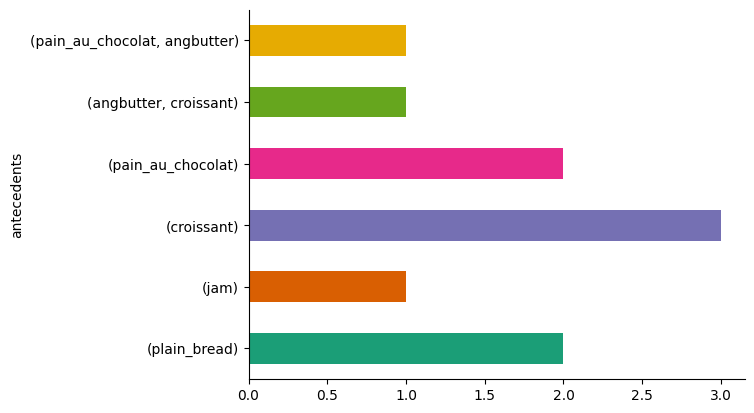

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('antecedents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Drop 'wiener' from sales_df and price_df
if 'Wiener' in sales_df.columns:
    sales_df.drop(columns='Wiener', inplace=True)

price_df = price_df[price_df['item'] != 'Wiener']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define warm brown palette
bakery_palette = ["#4E3620", "#8B5E3C", "#B0885A", "#D2B48C", "#EED6B3", "#FFF3E0"]
sns.set_palette(sns.color_palette(bakery_palette))
sns.set_style("whitegrid")


<ipython-input-48-cea54b449d4e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_sales.values, y=item_sales.index, palette=bakery_palette)
<ipython-input-48-cea54b449d4e>:5: UserWarning: 
The palette list has fewer values (6) than needed (21) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=item_sales.values, y=item_sales.index, palette=bakery_palette)
<ipython-input-48-cea54b449d4e>:9: UserWarning: Glyph 127838 (\N{BREAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127838 (\N{BREAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


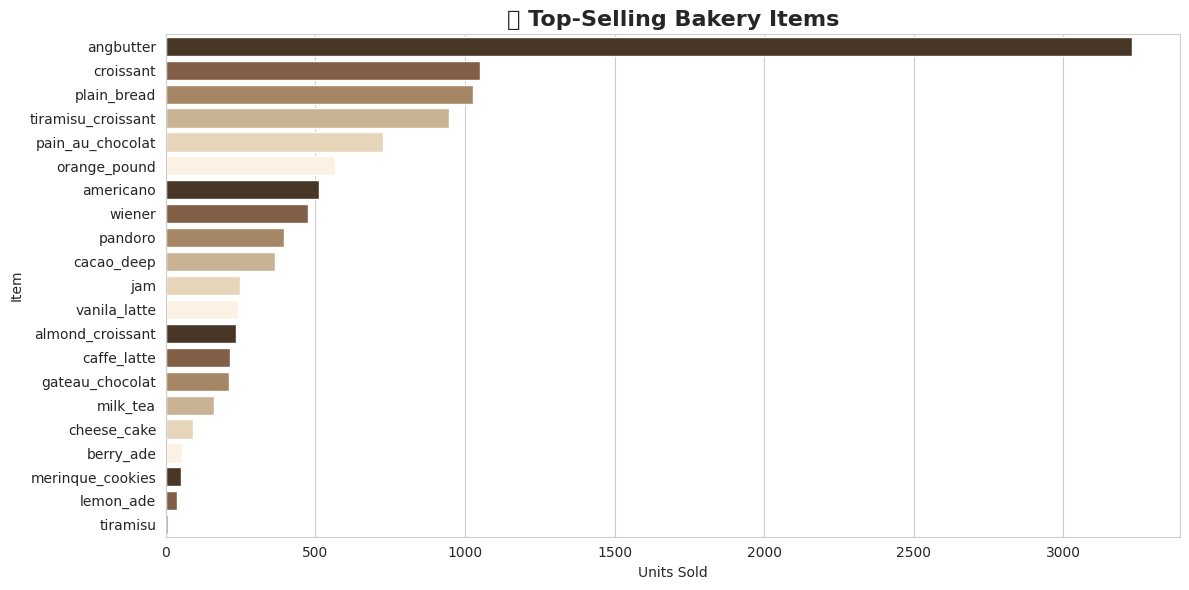

In [ ]:
# Sum total quantity sold per item
item_sales = sales_df[product_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=item_sales.values, y=item_sales.index, palette=bakery_palette)
plt.title("🍞 Top-Selling Bakery Items", fontsize=16, fontweight='bold')
plt.xlabel("Units Sold")
plt.ylabel("Item")
plt.tight_layout()
plt.show()


<ipython-input-49-951da9745349>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_revenue.values, y=item_revenue.index, palette=bakery_palette)
<ipython-input-49-951da9745349>:8: UserWarning: 
The palette list has fewer values (6) than needed (21) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=item_revenue.values, y=item_revenue.index, palette=bakery_palette)
<ipython-input-49-951da9745349>:12: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


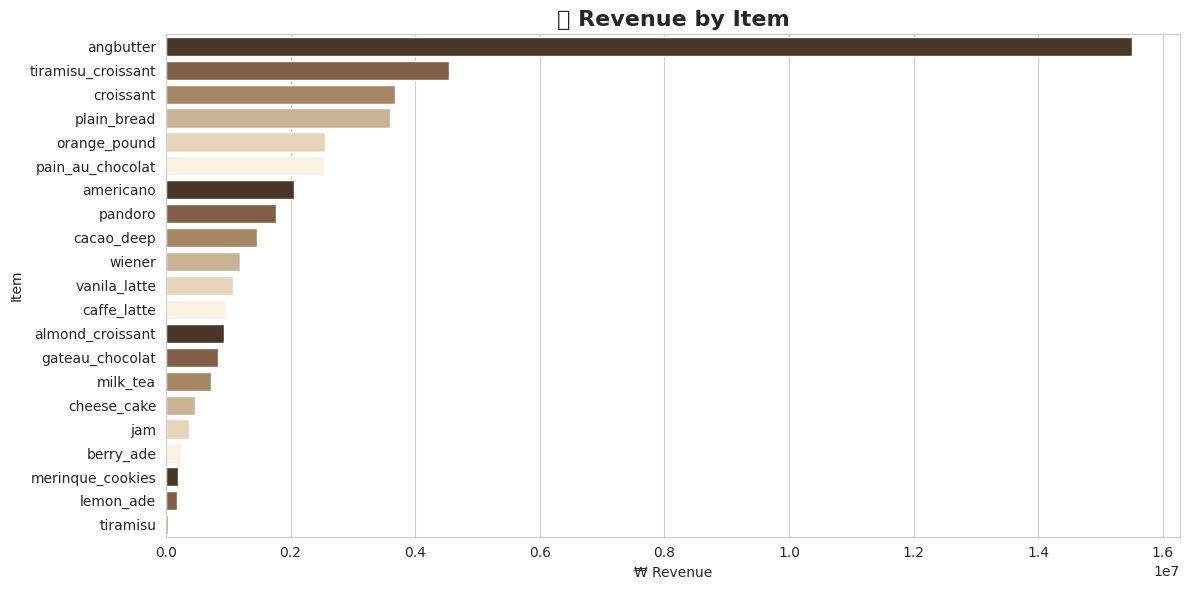

In [ ]:
# Sum revenue columns
revenue_cols = [f"{item}_revenue" for item in product_cols if f"{item}_revenue" in sales_df.columns]
item_revenue = sales_df[revenue_cols].sum()
item_revenue.index = [col.replace('_revenue', '') for col in item_revenue.index]
item_revenue = item_revenue.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=item_revenue.values, y=item_revenue.index, palette=bakery_palette)
plt.title("💵 Revenue by Item", fontsize=16, fontweight='bold')
plt.xlabel("₩ Revenue")
plt.ylabel("Item")
plt.tight_layout()
plt.show()


<ipython-input-50-38d23068c46d>:10: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127850 (\N{COOKIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


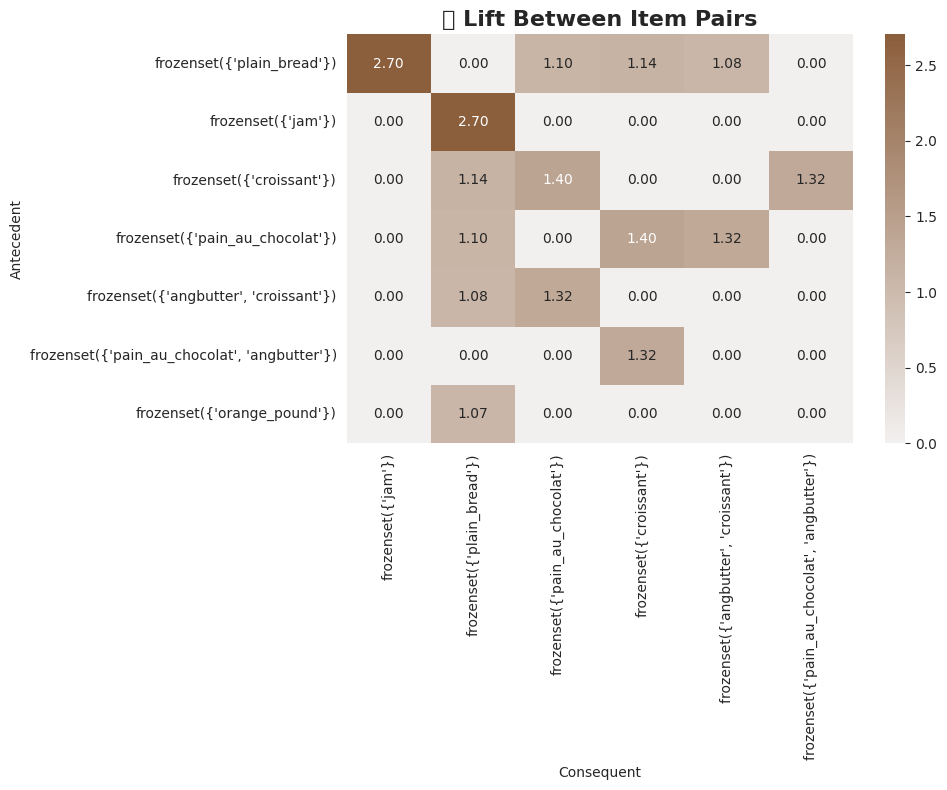

In [ ]:
# Optional: Heatmap of top association rules
top_rules = rules_sorted.head(15)
plt.figure(figsize=(10, 8))
heatmap_data = top_rules.pivot_table(index='antecedents', columns='consequents', values='lift', fill_value=0)

sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=sns.light_palette("#8B5E3C", as_cmap=True))
plt.title("🍪 Lift Between Item Pairs", fontsize=16, fontweight='bold')
plt.xlabel("Consequent")
plt.ylabel("Antecedent")
plt.tight_layout()
plt.show()


<ipython-input-53-d78fd689c918>:11: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


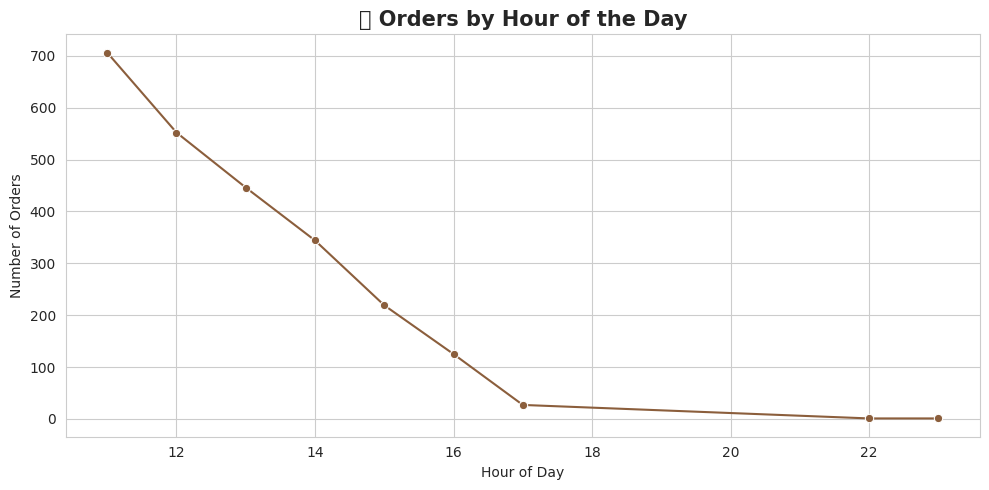

In [ ]:
# Extract hour
sales_df['order_hour'] = pd.to_datetime(sales_df['datetime']).dt.hour
orders_by_hour = sales_df['order_hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=orders_by_hour.index, y=orders_by_hour.values, marker="o", color="#8B5E3C")
plt.title("⏰ Orders by Hour of the Day", fontsize=15, fontweight='bold')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-112-ead2037226fe>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-112-ead2037226fe>:4: UserWarning:


The palette list has fewer values (7) than needed (10) and will cycle, which may produce an uninterpretable plot.



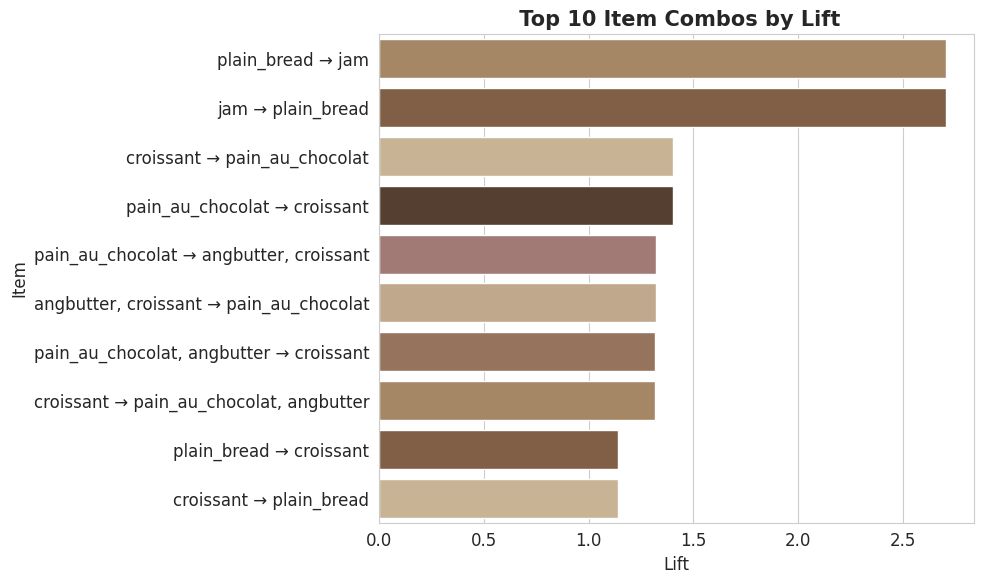

In [ ]:
top_rules_lift = rules_sorted.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_rules_lift['lift'],
    y=top_rules_lift.apply(lambda x: f"{', '.join(list(x['antecedents']))} → {', '.join(list(x['consequents']))}", axis=1),
    palette=bakery_palette
)
plt.title(" Top 10 Item Combos by Lift", fontsize=15, fontweight='bold')
plt.xlabel("Lift")
plt.ylabel("Item")
plt.tight_layout()
plt.show()


<ipython-input-55-338c0bf02ddd>:10: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


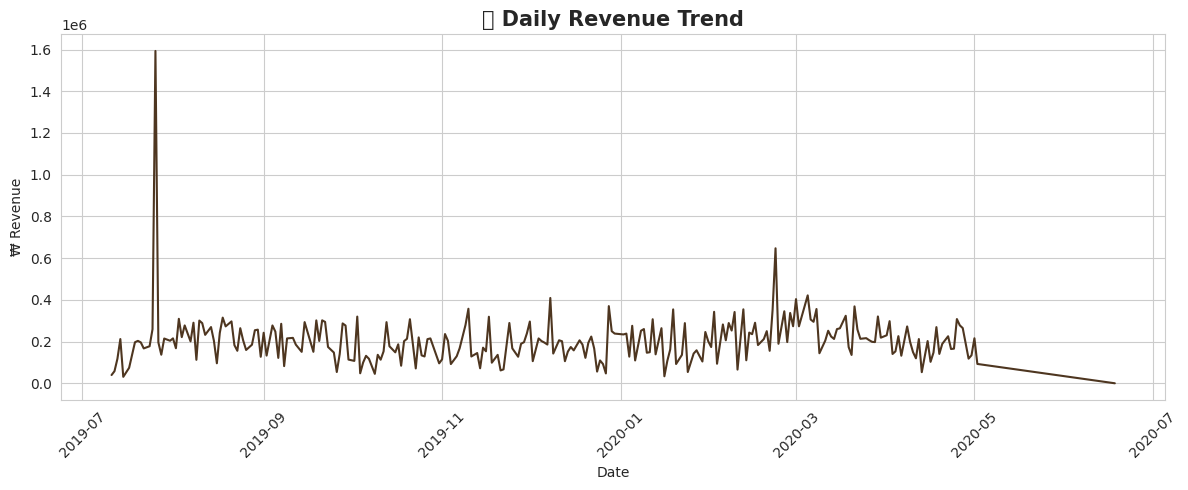

In [ ]:
sales_df['order_date'] = pd.to_datetime(sales_df['datetime']).dt.date
daily_revenue = sales_df.groupby('order_date')['total'].sum()

plt.figure(figsize=(12, 5))
sns.lineplot(x=daily_revenue.index, y=daily_revenue.values, color="#4E3620")
plt.title("📈 Daily Revenue Trend", fontsize=15, fontweight='bold')
plt.ylabel("₩ Revenue")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-56-e3e01d941011>:6: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


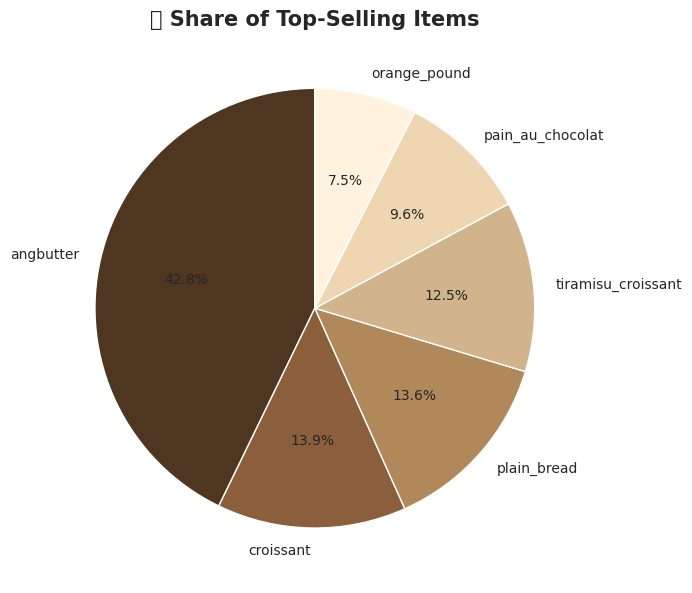

In [ ]:
top_items = item_sales.head(6)
plt.figure(figsize=(7, 7))
plt.pie(top_items.values, labels=top_items.index, autopct='%1.1f%%',
        colors=bakery_palette[:6], startangle=90, wedgeprops={'edgecolor': 'white'})
plt.title("🍩 Share of Top-Selling Items", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


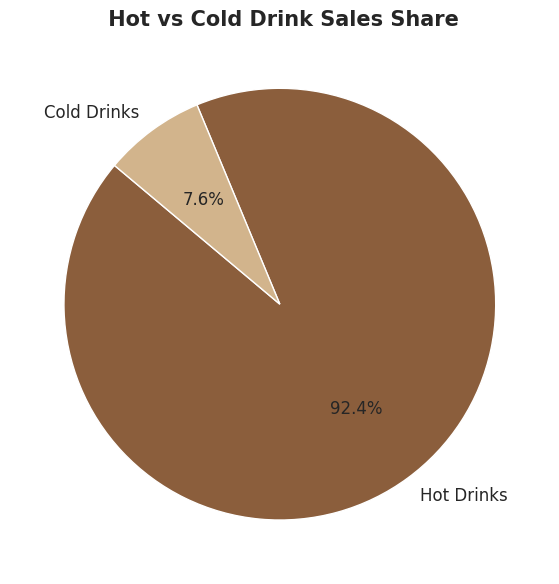

In [ ]:
# Define your own mapping
hot_drinks = ['americano', 'caffe_latte', 'vanila_latte', 'milk_tea']
cold_drinks = ['lemon_ade', 'berry_ade']

hot_sales = sales_df[hot_drinks].sum().sum()
cold_sales = sales_df[cold_drinks].sum().sum()

plt.figure(figsize=(6, 6))
plt.pie([hot_sales, cold_sales],
        labels=['Hot Drinks', 'Cold Drinks'],
        autopct='%1.1f%%', colors=['#8B5E3C', '#D2B48C'],
        startangle=140, wedgeprops={'edgecolor': 'white'})
plt.title(" Hot vs Cold Drink Sales Share", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

# Define drink-related columns (modify if you have more)
drink_items = [
    'americano', 'caffe_latte', 'milk_tea', 'vanila_latte',
    'lemon_ade', 'berry_ade'
]

# Drop missing items if any
existing_drinks = [item for item in drink_items if item in sales_df.columns]

# Total quantity sold per drink
drink_sales = sales_df[existing_drinks].sum()

# Clean names
clean_names = [name.replace('_', ' ').title() for name in drink_sales.index]

# Bakery pastel palette for drinks
drink_palette = ['#C7A27C', '#D6A77A', '#ECD9C6', '#FFE6CC', '#CBB8A9', '#BFA6A0']

# Plot
fig = px.pie(
    names=clean_names,
    values=drink_sales.values,
    title="🥤 Drink Sales Distribution",
    hole=0.4,
    color_discrete_sequence=drink_palette
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    title_font=dict(size=18, color="#4E3620", family="Georgia"),
    paper_bgcolor="#FFFDF8",
    plot_bgcolor="#FFFDF8"
)

fig.show()


In [ ]:
import plotly.express as px

# List of drink-related items
drink_items = [
    'americano', 'caffe_latte', 'milk_tea', 'vanila_latte',
    'lemon_ade', 'berry_ade'
]

# Keep only existing columns
existing_drinks = [item for item in drink_items if item in sales_df.columns]

# Sum quantity sold
drink_sales = sales_df[existing_drinks].sum()

# Clean names for display
clean_names = [name.replace('_', ' ').title() for name in drink_sales.index]

# Bakery-inspired color palette
bakery_drink_palette = ['#A47551', '#D6A77A', '#ECD9C6', '#FFE6CC', '#CBB8A9', '#BFA6A0']

# Plot standard pie chart (not donut)
fig = px.pie(
    names=clean_names,
    values=drink_sales.values,
    title="🥤 Drink Sales Distribution",
    color_discrete_sequence=bakery_drink_palette
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    title_font=dict(size=18, color="#4E3620", family="Georgia"),
    paper_bgcolor="#FFFDF8",
    plot_bgcolor="#FFFDF8"
)

fig.show()


<ipython-input-93-578b8ea75711>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


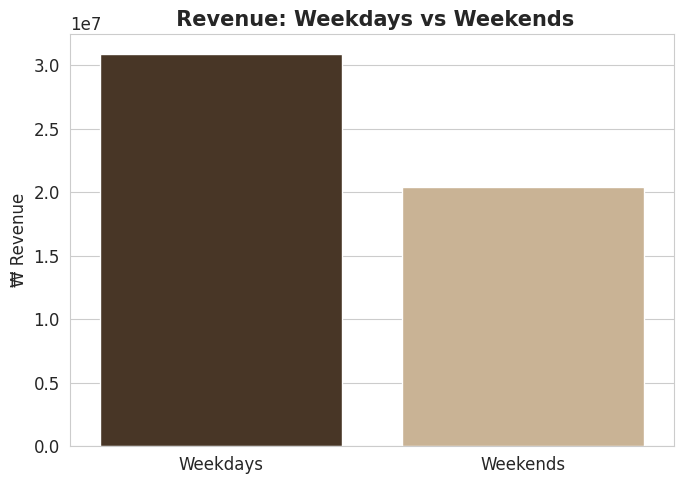

In [ ]:
# 1. Clean and map day names correctly
day_mapping = {
    'Mon': 'Monday',
    'Tues': 'Tuesday',
    'Wed': 'Wednesday',
    'Thur': 'Thursday',
    'Fri': 'Friday',
    'Sat': 'Saturday',
    'Sun': 'Sunday'
}

# Only map if needed
sales_df['day_of_week'] = sales_df['day_of_week'].replace(day_mapping)

# 2. Filter weekday/weekend orders
weekday_orders = sales_df[sales_df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekend_orders = sales_df[sales_df['day_of_week'].isin(['Saturday', 'Sunday'])]

# 3. Plot with elegant bakery aesthetic
plt.figure(figsize=(7, 5))
sns.barplot(
    x=['Weekdays', 'Weekends'],
    y=[weekday_orders['total'].sum(), weekend_orders['total'].sum()],
    palette=['#4E3620', '#D2B48C']  # Rich brown & warm tan
)
plt.title(" Revenue: Weekdays vs Weekends", fontsize=15, fontweight='bold')
plt.ylabel("₩ Revenue")
plt.tight_layout()
plt.show()



<ipython-input-60-3824032c656c>:8: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


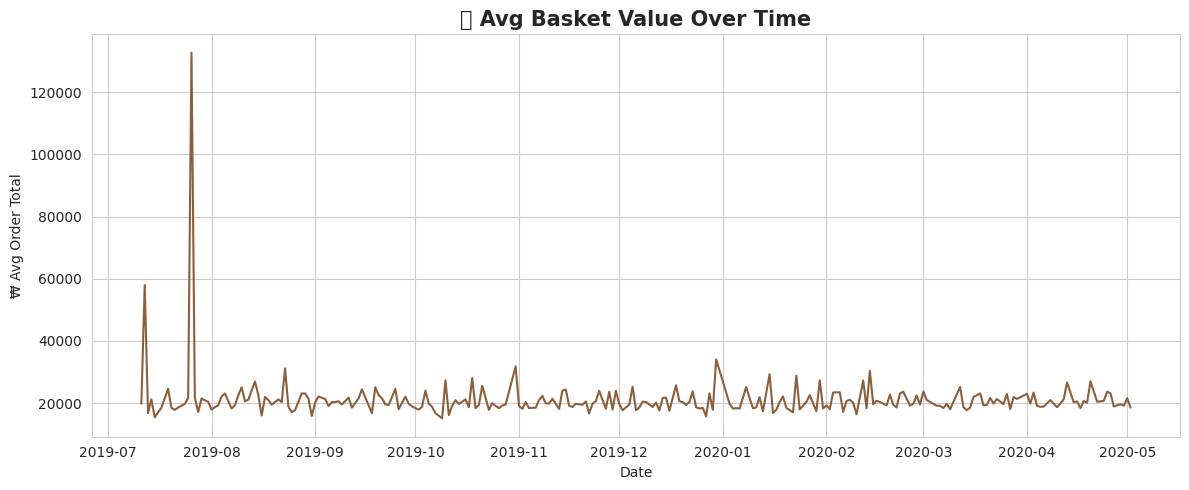

In [ ]:
avg_basket = sales_df.groupby('order_date')['total'].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x=avg_basket.index, y=avg_basket.values, color="#8B5E3C")
plt.title("🧾 Avg Basket Value Over Time", fontsize=15, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("₩ Avg Order Total")
plt.tight_layout()
plt.show()


In [ ]:
print(sales_df.columns.tolist())


['datetime', 'day_of_week', 'total', 'place', 'angbutter', 'plain_bread', 'jam', 'americano', 'croissant', 'caffe_latte', 'tiramisu_croissant', 'cacao_deep', 'pain_au_chocolat', 'almond_croissant', 'croque_monsieur', 'mad_garlic', 'milk_tea', 'gateau_chocolat', 'pandoro', 'cheese_cake', 'lemon_ade', 'orange_pound', 'wiener', 'vanila_latte', 'berry_ade', 'tiramisu', 'merinque_cookies', 'date', 'month', 'hour', 'day_name', 'angbutter_revenue', 'plain_bread_revenue', 'jam_revenue', 'croissant_revenue', 'tiramisu_croissant_revenue', 'cacao_deep_revenue', 'pain_au_chocolat_revenue', 'almond_croissant_revenue', 'gateau_chocolat_revenue', 'pandoro_revenue', 'cheese_cake_revenue', 'lemon_ade_revenue', 'orange_pound_revenue', 'wiener_revenue', 'berry_ade_revenue', 'tiramisu_revenue', 'merinque_cookies_revenue', 'americano_revenue', 'caffe_latte_revenue', 'milk_tea_revenue', 'vanila_latte_revenue', 'order_hour', 'order_date']


<ipython-input-62-0e898b70a0a1>:42: UserWarning: Glyph 127855 (\N{HONEY POT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127855 (\N{HONEY POT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


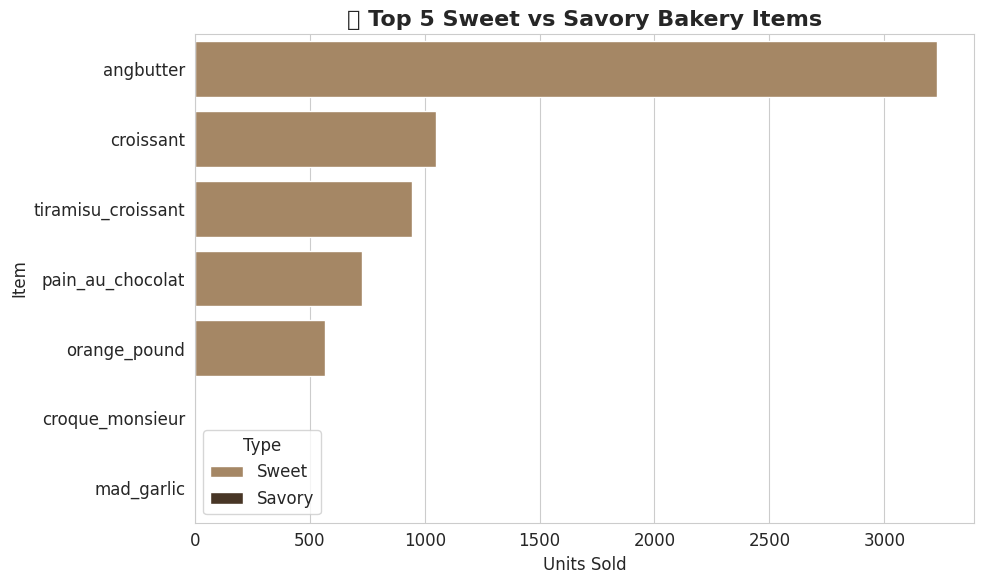

In [ ]:
# 1. Import Required Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Set Bakery Aesthetic
sns.set_palette(["#B0885A", "#8B5E3C", "#D2B48C", "#5A3E2B"])
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# 3. Define Item Categories
sweet_items = [
    'angbutter', 'croissant', 'tiramisu_croissant', 'cacao_deep',
    'pain_au_chocolat', 'almond_croissant', 'gateau_chocolat',
    'cheese_cake', 'orange_pound', 'tiramisu', 'merinque_cookies'
]
savory_items = ['croque_monsieur', 'mad_garlic']  # 'wiener' intentionally removed

# 4. Filter Valid Columns
valid_sweet_items = [item for item in sweet_items if item in sales_df.columns]
valid_savory_items = [item for item in savory_items if item in sales_df.columns]

# 5. Sum & Sort Top Sellers
sweet_sales = sales_df[valid_sweet_items].sum().sort_values(ascending=False).head(5)
savory_sales = sales_df[valid_savory_items].sum().sort_values(ascending=False).head(5)

# 6. Combine for Joint Plot
combined_items = pd.concat([sweet_sales, savory_sales])
combined_labels = ['Sweet'] * len(sweet_sales) + ['Savory'] * len(savory_sales)

# 7. Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=combined_items.values,
    y=combined_items.index,
    hue=combined_labels,
    palette={"Sweet": "#B0885A", "Savory": "#4E3620"}
)
plt.title("🍯 Top 5 Sweet vs Savory Bakery Items", fontsize=16, fontweight='bold')
plt.xlabel("Units Sold")
plt.ylabel("Item")
plt.legend(title="Type")
plt.tight_layout()
plt.show()


In [ ]:
print(sales_df['day_of_week'].unique())


['Thur' 'Fri' 'Sat' 'Sun' 'Mon' 'Wed' 'Tues' nan]


In [ ]:
# Step 1: Strip whitespace and standardize abbreviations
sales_df['day_of_week'] = sales_df['day_of_week'].str.strip().str.title()

# Step 2: Define a mapping from abbreviations to full day names
day_mapping = {
    'Mon': 'Monday',
    'Tues': 'Tuesday',
    'Wed': 'Wednesday',
    'Thur': 'Thursday',
    'Fri': 'Friday',
    'Sat': 'Saturday',
    'Sun': 'Sunday'
}

# Step 3: Apply the mapping
sales_df['day_of_week'] = sales_df['day_of_week'].map(day_mapping)


<ipython-input-95-d194d23b7939>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_by_day.index, y=revenue_by_day.values, palette=bakery_palette)


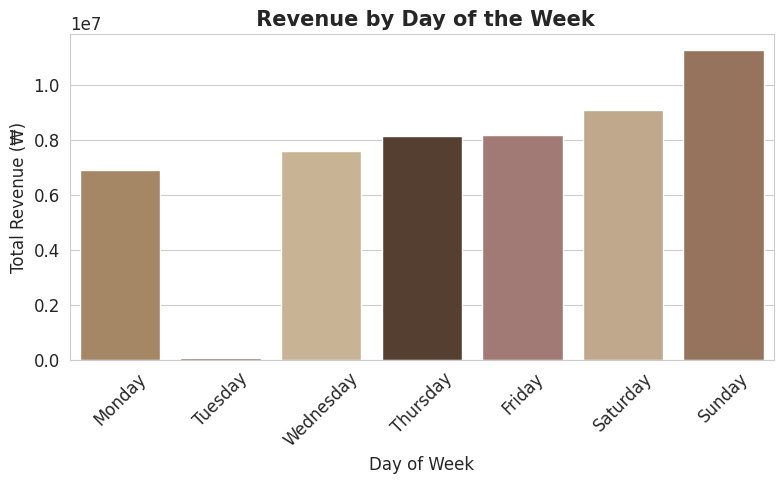

In [ ]:
# Revenue per day
revenue_by_day = sales_df.groupby('day_of_week')['total'].sum().reindex(day_order)

plt.figure(figsize=(8, 5))
sns.barplot(x=revenue_by_day.index, y=revenue_by_day.values, palette=bakery_palette)
plt.title(" Revenue by Day of the Week", fontsize=15, fontweight='bold')
plt.ylabel("Total Revenue (₩)")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


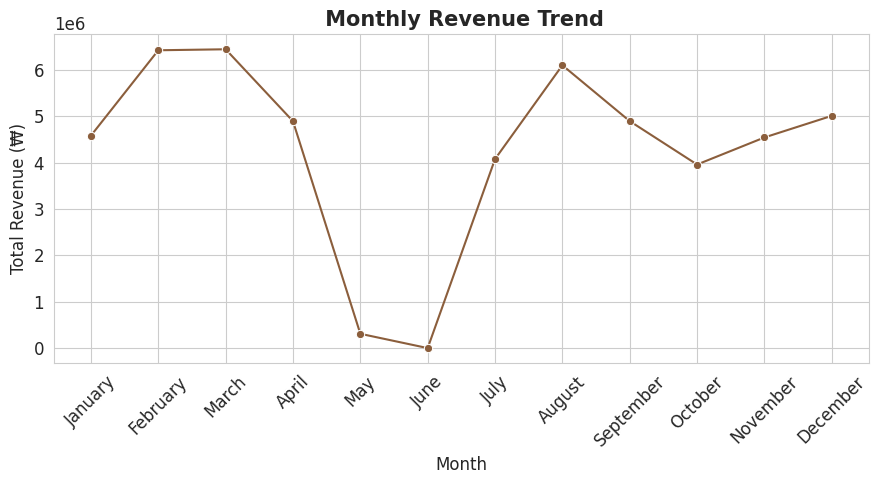

In [ ]:
import calendar

# Group and sort revenue by month
monthly_revenue = sales_df.groupby('month')['total'].sum().sort_index()

# Convert month numbers to full month names (January, February, etc.)
month_labels = [calendar.month_name[int(m)] for m in monthly_revenue.index]

# Plot
plt.figure(figsize=(9, 5))
sns.lineplot(x=month_labels, y=monthly_revenue.values, marker='o', color="#8B5E3C")
plt.title(" Monthly Revenue Trend", fontsize=15, fontweight='bold')
plt.ylabel("Total Revenue (₩)")
plt.xlabel("Month")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-72-7b9e6c108503>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_revenue.values, y=item_names, palette=soft_brown_palette[:len(item_names)])
<ipython-input-72-7b9e6c108503>:11: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


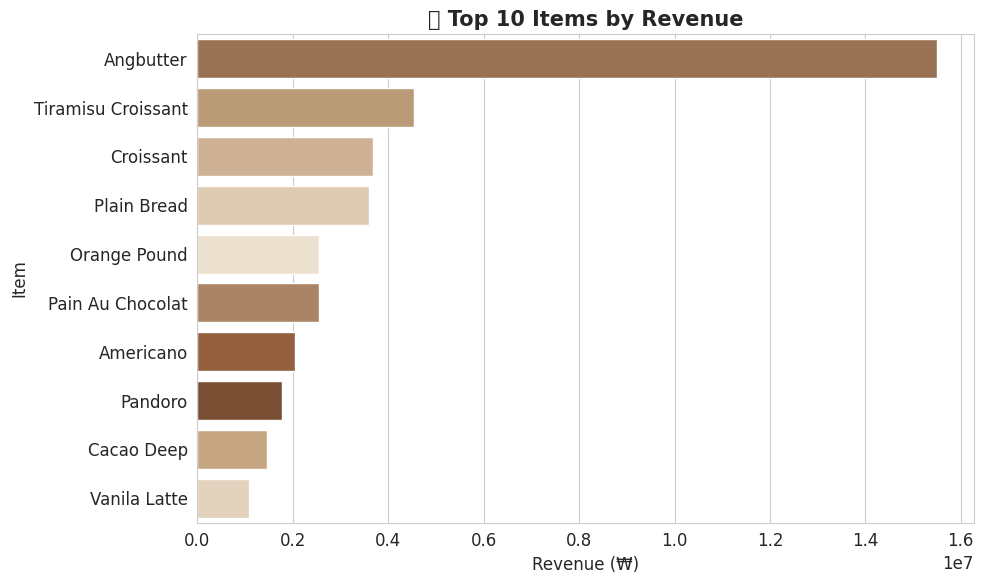

In [ ]:
# Define a warm, bakery-inspired custom palette
soft_brown_palette = ['#A47148', '#C49E6C', '#D8B28D', '#E5C9AA', '#F1E2CA',
                      '#B5835A', '#A25D32', '#844C29', '#D2A679', '#EAD2B6']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=item_revenue.values, y=item_names, palette=soft_brown_palette[:len(item_names)])
plt.title("🍩 Top 10 Items by Revenue", fontsize=15, fontweight='bold')
plt.xlabel("Revenue (₩)")
plt.ylabel("Item")
plt.tight_layout()
plt.show()


<ipython-input-69-e3e01d941011>:6: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


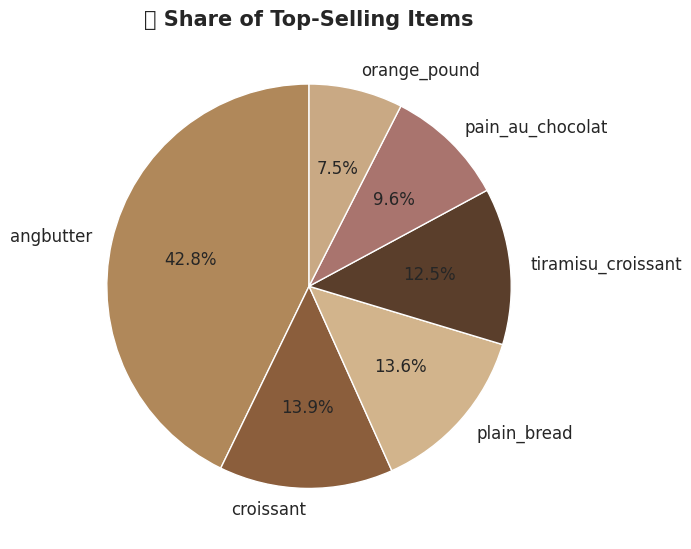

In [ ]:
top_items = item_sales.head(6)
plt.figure(figsize=(7, 7))
plt.pie(top_items.values, labels=top_items.index, autopct='%1.1f%%',
        colors=bakery_palette[:6], startangle=90, wedgeprops={'edgecolor': 'white'})
plt.title("🍩 Share of Top-Selling Items", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


<ipython-input-70-14f1b7706f6c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_order_value.index, y=avg_order_value.values, palette="Oranges")
<ipython-input-70-14f1b7706f6c>:9: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


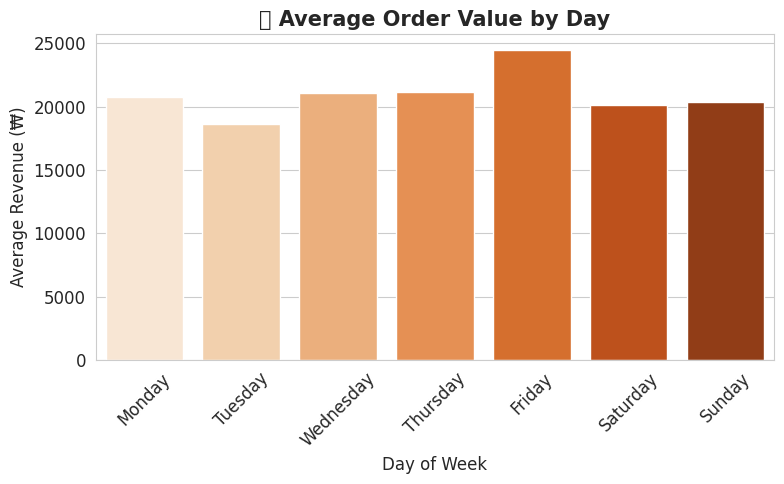

In [ ]:
avg_order_value = sales_df.groupby('day_of_week')['total'].mean().reindex(day_order)

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_order_value.index, y=avg_order_value.values, palette="Oranges")
plt.title("🧾 Average Order Value by Day", fontsize=15, fontweight='bold')
plt.ylabel("Average Revenue (₩)")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-71-cb7184c99e99>:14: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127849 (\N{DOUGHNUT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


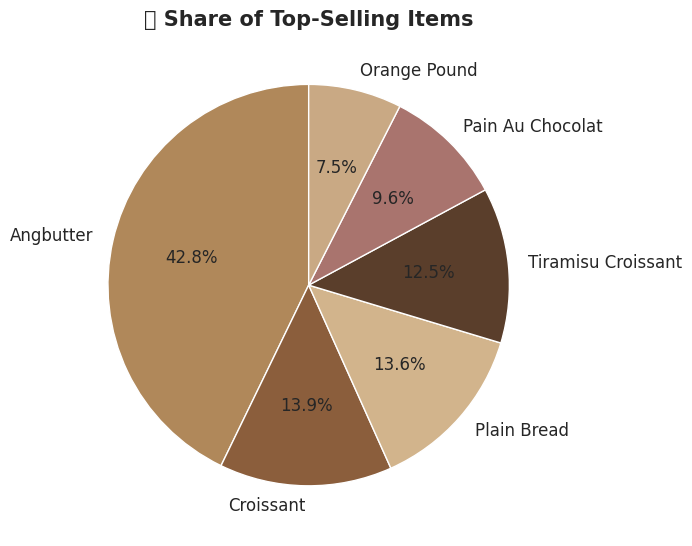

In [ ]:
# Format index labels (e.g., "orange_pound" → "Orange Pound")
formatted_labels = [item.replace('_', ' ').title() for item in top_items.index]

plt.figure(figsize=(7, 7))
plt.pie(
    top_items.values,
    labels=formatted_labels,
    autopct='%1.1f%%',
    colors=bakery_palette[:6],
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("🍩 Share of Top-Selling Items", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


<ipython-input-113-dd7a7d5cd128>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




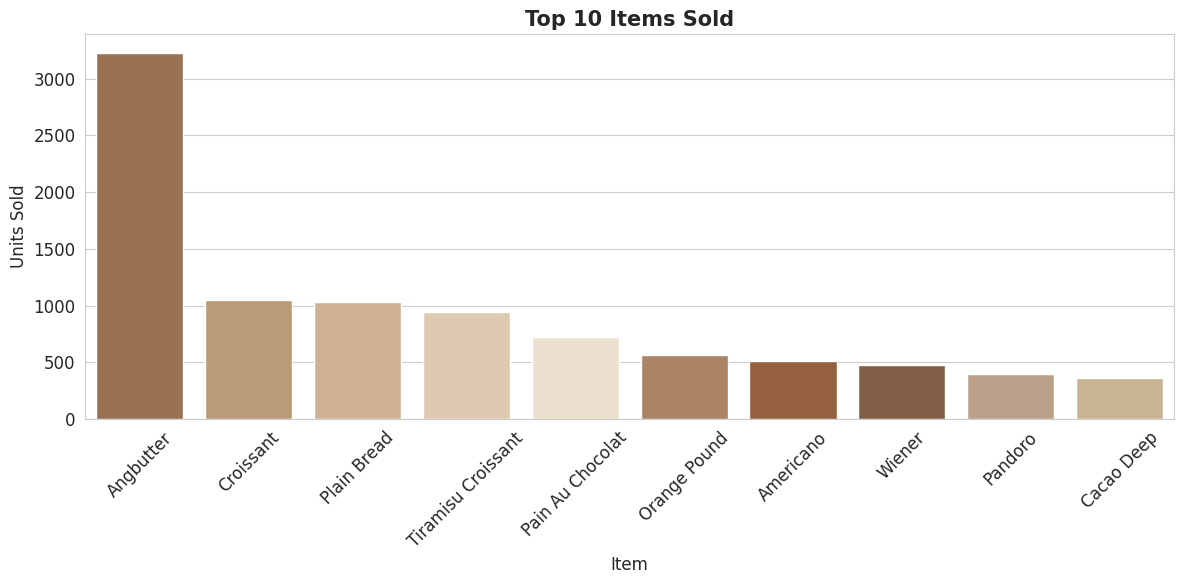

In [ ]:
# Filter out 'wiener' and get top 10 by units sold
filtered_summary = summary_df[summary_df['item'] != 'wiener']
top10_items = filtered_summary.sort_values('units_sold', ascending=False).head(10)

# Custom warm brown-toned palette
bakery_palette = ['#A47148', '#C49E6C', '#D8B28D', '#E5C9AA', '#F1E2CA',
                  '#B5835A', '#A25D32', '#8B5E3C', '#C29F80', '#D2B48C']

# Format item names for labels
top10_items['item'] = top10_items['item'].str.replace('_', ' ').str.title()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top10_items, x='item', y='units_sold', palette=bakery_palette[:len(top10_items)])
plt.title("Top 10 Items Sold", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel("Units Sold")
plt.xlabel("Item")
plt.tight_layout()
plt.show()


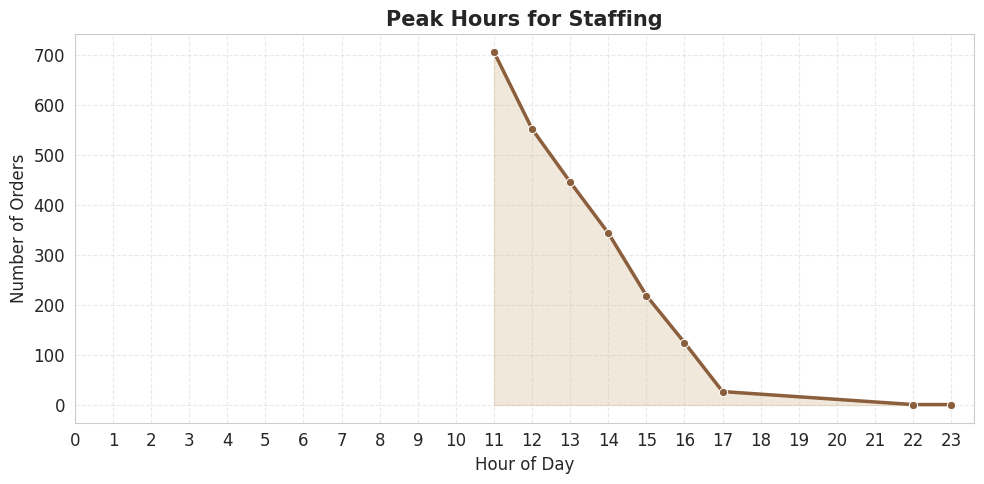

In [ ]:
# Hourly order count
orders_by_hour = sales_df.groupby('hour').size().reset_index(name='order_count')

plt.figure(figsize=(10,5))
sns.lineplot(data=orders_by_hour, x='hour', y='order_count', marker='o', color='#8B5E3C', linewidth=2.5)
plt.fill_between(orders_by_hour['hour'], orders_by_hour['order_count'], color='#D2B48C', alpha=0.3)
plt.title("Peak Hours for Staffing", fontsize=15, fontweight='bold')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


<ipython-input-116-51ed08b734b5>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




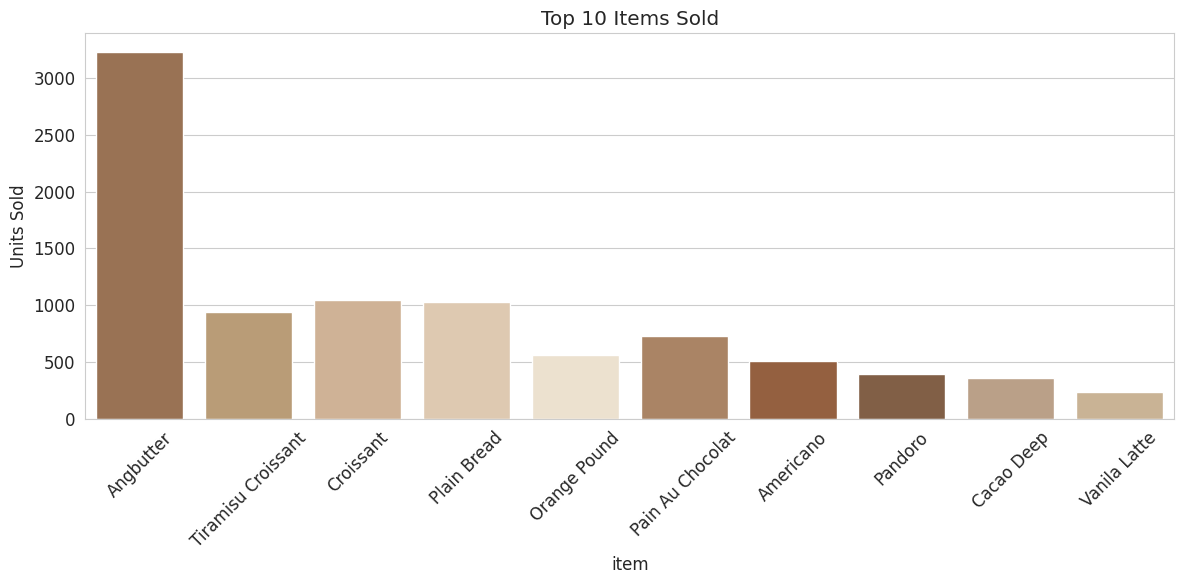

In [ ]:
# Exclude 'wiener' from top items analysis
summary_df_filtered = summary_df[summary_df['item'] != 'Wiener']

# Plot top 10 by quantity
plt.figure(figsize=(12,6))
sns.barplot(data=summary_df_filtered.head(10), x='item', y='units_sold', palette=bakery_palette)
plt.title("Top 10 Items Sold")
plt.xticks(rotation=45)
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()


<ipython-input-119-82423c32789b>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




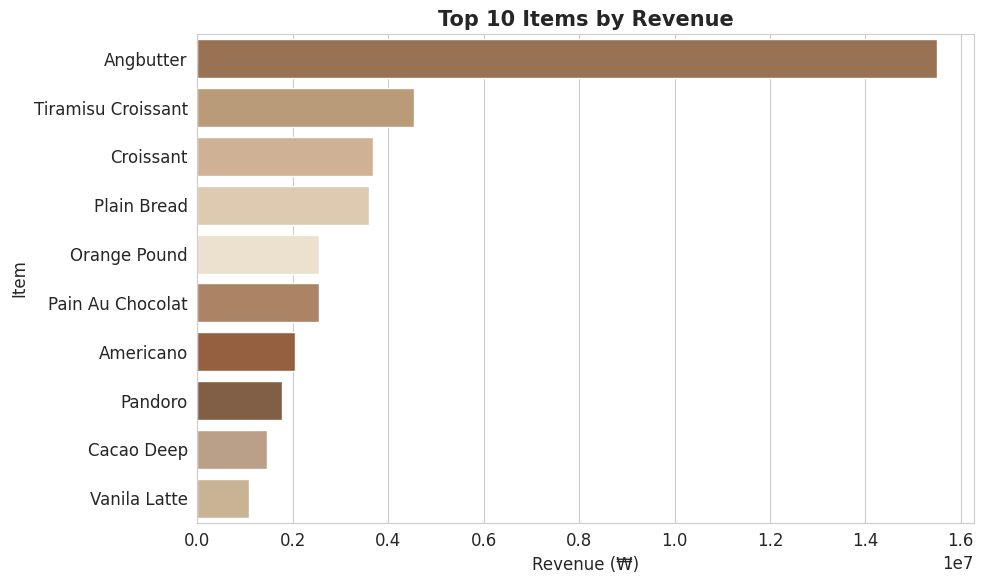

In [ ]:
# Get revenue columns excluding 'wiener'
revenue_cols = [col for col in sales_df.columns if col.endswith('_revenue') and 'wiener' not in col]

# Get top revenue-generating items
item_revenue = sales_df[revenue_cols].sum().sort_values(ascending=False).head(10)
item_names = [col.replace('_revenue', '').replace('_', ' ').title() for col in item_revenue.index]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=item_revenue.values, y=item_names, palette=bakery_palette)
plt.title("Top 10 Items by Revenue", fontsize=15, fontweight='bold')
plt.xlabel("Revenue (₩)")
plt.ylabel("Item")
plt.tight_layout()
plt.show()


<ipython-input-78-bd3e24f12c2a>:9: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


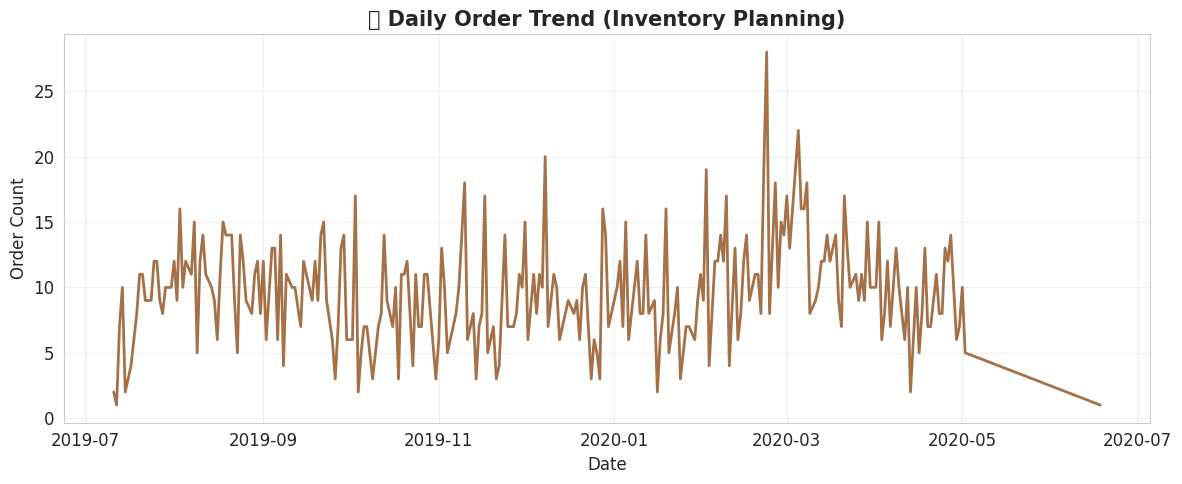

In [ ]:
daily_orders = sales_df.groupby('order_date').size()

plt.figure(figsize=(12,5))
plt.plot(daily_orders.index, daily_orders.values, color='#A47148', linewidth=2)
plt.title("📦 Daily Order Trend (Inventory Planning)", fontsize=15, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Order Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


<ipython-input-85-f66a0de38328>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ingredient_usage.values, y=ingredient_usage.index.str.replace('_', ' ').str.title(), palette=bakery_palette)
<ipython-input-85-f66a0de38328>:7: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x=ingredient_usage.values, y=ingredient_usage.index.str.replace('_', ' ').str.title(), palette=bakery_palette)


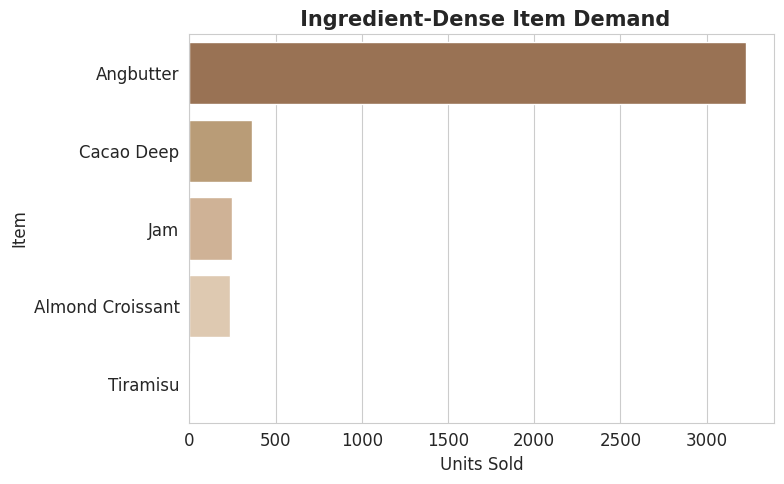

In [ ]:
# Example: assume ingredient-heavy items
ingredient_items = ['angbutter', 'jam', 'cacao_deep', 'almond_croissant', 'tiramisu']

ingredient_usage = sales_df[ingredient_items].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=ingredient_usage.values, y=ingredient_usage.index.str.replace('_', ' ').str.title(), palette=bakery_palette)
plt.title(" Ingredient-Dense Item Demand", fontsize=15, fontweight='bold')
plt.xlabel("Units Sold")
plt.ylabel("Item")
plt.tight_layout()
plt.show()


<ipython-input-101-a1fa530c5a97>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_names, y=monthly_revenue.values, palette=bakery_palette)
<ipython-input-101-a1fa530c5a97>:14: UserWarning: 
The palette list has fewer values (7) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=month_names, y=monthly_revenue.values, palette=bakery_palette)


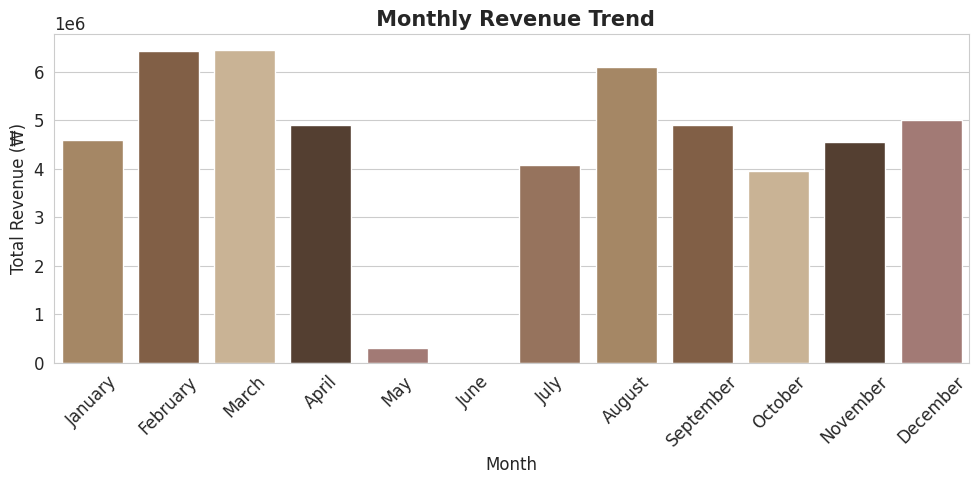

In [ ]:
import calendar

# Ensure month column is numeric (integer)
sales_df['month'] = pd.to_datetime(sales_df['datetime']).dt.month

# Group revenue by month number
monthly_revenue = sales_df.groupby('month')['total'].sum()

# Convert float month index to int before mapping
month_names = [calendar.month_name[int(m)] for m in monthly_revenue.index]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=month_names, y=monthly_revenue.values, palette=bakery_palette)
plt.title(" Monthly Revenue Trend", fontsize=15, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Total Revenue (₩)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd # Ensure pandas is imported

# Assuming 'quantity' is a pandas Series from a previous step
# If 'quantity' is not defined, you need to define it first, e.g.:
# quantity = sales_df[product_cols].sum().sort_values(ascending=False)
# amounts = quantity.values # Assuming 'amounts' was intended to be the values of 'quantity'


# Drop 'wiener' from the quantity Series
filtered_quantity = quantity.drop('wiener', errors='ignore')

# The values you need for the plot are now the values of the filtered_quantity Series
filtered_amounts = filtered_quantity.values

# Get the index (item names) from the filtered_quantity Series
clean_names = [name.replace('_', ' ').title() for name in filtered_quantity.index]

# Soft elegant bakery-inspired palette (pastel browns, creams, blushes)
pastel_bakery_palette = [
    '#D6A77A',  # Toasted caramel
    '#ECD9C6',  # Cream beige
    '#C7A27C',  # Light mocha
    '#FFE6CC',  # Vanilla cream
    '#CBB8A9',  # Light cinnamon
    '#BFA6A0',  # Milk coffee
    '#8B5E3C',  # Rich chocolate
    '#F6E2B3',  # Buttercream
    '#DCC5B1',  # Almond milk
    '#EFD9CE'   # Blush cream
]

# Create donut chart
fig = px.pie(
    names=clean_names,
    values=filtered_amounts,
    title="🍪 Product Sales Volume Distribution",
    hole=0.4,
    color_discrete_sequence=pastel_bakery_palette
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    title_font=dict(size=18, color="#4E3620", family="Georgia"),
    paper_bgcolor="#FFFDF8",
    plot_bgcolor="#FFFDF8"
)

fig.show()